<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Custom-functions" data-toc-modified-id="Custom-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Custom functions</a></span></li><li><span><a href="#Environment-variables" data-toc-modified-id="Environment-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Environment variables</a></span></li><li><span><a href="#Load-and-process-dataset" data-toc-modified-id="Load-and-process-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load and process dataset</a></span></li><li><span><a href="#Define-model-and-model-parameters" data-toc-modified-id="Define-model-and-model-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define model and model parameters</a></span></li><li><span><a href="#Define-loss-and-accuracy-metrics" data-toc-modified-id="Define-loss-and-accuracy-metrics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define loss and accuracy metrics</a></span></li><li><span><a href="#Define-checkpoint-options" data-toc-modified-id="Define-checkpoint-options-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Define checkpoint options</a></span></li><li><span><a href="#Training-function-and-loop" data-toc-modified-id="Training-function-and-loop-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training function and loop</a></span></li><li><span><a href="#Plot-loss-and-accuracy-graphs" data-toc-modified-id="Plot-loss-and-accuracy-graphs-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot loss and accuracy graphs</a></span></li><li><span><a href="#Evaluate-model-and-test-prediction" data-toc-modified-id="Evaluate-model-and-test-prediction-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Evaluate model and test prediction</a></span></li></ul></div>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# %cd /content/drive/My Drive/Colab Notebooks/accent/src

/content/drive/My Drive/Colab Notebooks/accent/src


### Import packages

In [1]:
import re, zipfile, os, io, time, string, numpy as np, matplotlib.ticker as ticker, \
            matplotlib.pyplot as plt
from token_list import strip_tokens

# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.__version__

'2.0.0'

In [2]:
# x = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH se den han trong 2 ngay toi. So tien  2.999.898 VND, TK 12345678912. Bo qua neu da TT. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH da qua han 1 ngay. TK 12345678912, so tien2.999.898 VND. Bo qua neu da TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 6 ngay va bi tinh phat 250,000. TK 12345678912, so tien 2.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'KH da qua han 5 ky no. TK 12345678912, so tien 12.999.898VND. Vui long TT ngay lap tuc. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da bi tinh phat do lien tuc vi pham. TK12345678912, so tien 12.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 91 ngay. Vui long TT toan bo29.999.898VND vao TK 12345678912 hom nay. Thong tin chi tiet, lien he 18006288',
# 'Chung toi vua nhan thanh toan khoan vay cua KH tu TK12345678912. TUY NHIEN, KH van con thieu 29.999.898VND. Vui long TT toan ngay lap tuc. Cam on']

# x = [seq.replace(',', ' ,') for seq in x]
# x = [seq.replace('.', ' .') for seq in x]
# g = [len(seq.split()) for seq in x]
# g

### Custom functions

In [3]:
def process_raw(raw_data):
    raw_data = [seq.lower().strip() for seq in raw_data]

    # Creating a space between a word and the punctuation following it
    raw_data = [re.sub(r"([?.!,¿])", r" \1 ", seq) for seq in raw_data]
    raw_data = [re.sub(r'[" "]+', " ", seq) for seq in raw_data]

    # Replacing everything with space except (characters, ".", "?", "!", ",")
    filtered_punctuations = string.punctuation
    exclude = [',', '!', '.', '?']

    for c in filtered_punctuations:
        if c in exclude:
            filtered_punctuations = filtered_punctuations.replace(c, '')

    table = str.maketrans('', '', filtered_punctuations)
    raw_data = [seq.translate(table) for seq in raw_data]
    
    # Append start and end tokens to sequences
    processed_raw = []
    for seq in raw_data:
        words = seq.split()
        words = [word.strip() for word in words]
        processed_raw.append(' '.join(words))

    processed_raw = ['<s> ' + seq + ' <e>' for seq in processed_raw]

    return processed_raw

In [4]:
def generate_input(processed_raw):
    output = ''
    for char in processed_raw:
        if char in strip_tokens:
            output += strip_tokens[char]
        else:
            output += char          
    return output

In [5]:
def get_max_len(input_data, get_index=False): 
    longest = [len(data.split()) for data in input_data]
    if get_index:
        print(longest.index(max(longest)))
    return max(longest)

In [6]:
def tokenize_pad_data(data, pad_len=None):
    tk = Tokenizer(char_level=False, filters='')
    tk.fit_on_texts(data)
    data = tk.texts_to_sequences(data)
    data = pad_sequences(data, padding='post', maxlen=pad_len)
    return data, tk

In [7]:
def process_data(processed_input, processed_target, pad_len=None):    
    tokenized_input, input_tokenizer = tokenize_pad_data(data=processed_input, pad_len=pad_len)
    tokenized_target, target_tokenizer = tokenize_pad_data(data=processed_target, pad_len=pad_len)
    return tokenized_input, input_tokenizer, tokenized_target, target_tokenizer

In [8]:
def convert(tokenizer, tokenized_data, send_back=False):
    original = []
    
    for token in tokenized_data:
        if token != 0:
            if token in tokenizer.index_word:
                original.append(tokenizer.index_word[token])
            else:
                original.append('<unk>')
    
    if send_back:
        return original

In [9]:
def evaluate(sentence):
    attention_plot = np.zeros((max_process_seq, max_process_seq))

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_process_seq, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = tf.zeros((1, units))
    cell = tf.zeros((1, units))
    enc_out, enc_hidden = encoder(inputs, hidden, cell)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']], 0)

    for t in range(max_process_seq):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<e>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
      
    return result, sentence, attention_plot

In [10]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [11]:
def restore(sentence, plot=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if plot:
      attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    
    return result

### Environment variables

In [12]:
# Define data arguements
# Set random seed
np.random.seed(50)
data_file = '../data/raw/raw_train.txt'

### Load and process dataset

In [13]:
# Load dataset
counter = 0
max_seq_len = 40
no_seq = 30000
raw_data = []

# Load raw data and read first 100000 sequences with 40 or less words
with open(data_file, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if 10 <= len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            continue

In [14]:
# Process dataset
# Process raw and input data
filtered_raw = process_raw(raw_data)
processed_inp = [generate_input(seq) for seq in filtered_raw]

# Get max sequence length after processing
max_process_seq = get_max_len(processed_inp, get_index=False)
print('Max input sequence length: {}'.format(get_max_len(processed_inp)))
print('Max target sequence length: {}'.format(get_max_len(filtered_raw)))

Max input sequence length: 49
Max target sequence length: 49


In [15]:
print('Input Sample:')
print(processed_inp[-1])
print('\n')
print('Target Sample:')
print(filtered_raw[-1])

Input Sample:
<s> ngan hang quoc gia dua ra mot lai suat nhat dinh khi dua tien cho cac ngan hang thuong mai , goi la lai suat co ban . <e>


Target Sample:
<s> ngân hàng quốc gia đưa ra một lãi suất nhất định khi đưa tiền cho các ngân hàng thương mại , gọi là lãi suất cơ bản . <e>


In [16]:
# Tokenize/pad input and target data, generates corresponding tokenizers
tokenized_input, input_tokenizer, tokenized_target, target_tokenizer = process_data(processed_input=processed_inp, 
                                                            processed_target=filtered_raw, pad_len=max_process_seq)

In [17]:
train_data_len = round((.8 * no_seq))
val_test_data_len = round((.1 * no_seq))

train_inp_data, train_tar_data = tokenized_input[:train_data_len], tokenized_target[:train_data_len]
val_inp_data, val_tar_data = tokenized_input[train_data_len:(train_data_len+val_test_data_len)], \
                                    tokenized_target[train_data_len:(train_data_len+val_test_data_len)]
test_inp_data, test_tar_data = tokenized_input[-val_test_data_len:], tokenized_target[-val_test_data_len:]

print('Number of training sequences: {}'.format(len(train_inp_data)))
print('Number of val sequences: {}'.format(len(val_inp_data)))
print('Number of test sequences: {}'.format(len(test_inp_data)))

Number of training sequences: 24000
Number of val sequences: 3000
Number of test sequences: 3000


In [18]:
convert(input_tokenizer, train_inp_data[0])

In [19]:
train_buffer_sz = len(train_inp_data)
val_buffer_sz = len(val_inp_data)
test_buffer_sz = len(test_inp_data)
batch_sz = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_data, train_tar_data)).shuffle(train_buffer_sz)
train_dataset = train_dataset.batch(batch_sz, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_data, val_tar_data)).shuffle(val_buffer_sz)
val_dataset = val_dataset.batch(batch_sz, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_inp_data, test_tar_data)).shuffle(test_buffer_sz)
test_dataset = test_dataset.batch(batch_sz, drop_remainder=True)

In [20]:
example_input_batch, example_target_batch = next(iter(train_dataset))
# example_input_batch.shape, example_target_batch.shape

example_val_inp_batch, example_val_tar_batch = next(iter(val_dataset))
# example_val_inp_batch.shape, example_val_tar_batch.shape

example_test_inp_batch, example_test_tar_batch = next(iter(test_dataset))
# example_test_inp_batch.shape, example_test_tar_batch.shape

### Define model and model parameters

In [21]:
embedding_dim = 256
units = 512
dropout = 0.3
inp_vocab_sz = len(input_tokenizer.index_word)+1
tar_vocab_sz = len(target_tokenizer.index_word)+1

print('Input vocabulary: {}'.format(inp_vocab_sz))
print('Target vocabulary: {}'.format(tar_vocab_sz))

Input vocabulary: 14130
Target vocabulary: 17408


In [22]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)

            
  def call(self, x, hidden, cell):
    x = self.embedding(x)
    output, state, cell = self.lstm(x, initial_state = [hidden, cell])
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

  def initialize_cell_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [23]:
encoder = Encoder(inp_vocab_sz, embedding_dim, units, batch_sz)

# sample input
# sample_hidden = encoder.initialize_hidden_state()
# sample_cell = encoder.initialize_cell_state()
# sample_output, sample_hidden = encoder(example_input_batch, sample_hidden, sample_cell)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
# print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden[0].shape))

In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
# attention_layer = BahdanauAttention(512)
# attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
# print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [26]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state, cell = self.lstm(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [27]:
decoder = Decoder(tar_vocab_sz, embedding_dim, units, batch_sz)

# sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_sz, 1)), sample_hidden, sample_output)

# print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

### Define loss and accuracy metrics

In [28]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

### Define checkpoint options

In [29]:
checkpoint_dir = './training_checkpoints'
  
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=1)

### Training function and loop

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden, enc_cell):
    loss = 0.0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden, enc_cell)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

        # Teacher forcing, feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # Passing the Encoder output to the Decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)      
            loss += loss_function(targ[:, t], predictions)
                   
            # Teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
      
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))    
    batch_loss = loss / int(targ.shape[1])

    return batch_loss

In [31]:
@tf.function
def test_step(inp, targ, enc_hidden, enc_cell):
  loss = 0.0
  
  enc_output, enc_hidden = encoder(inp, enc_hidden, enc_cell)
  dec_hidden = enc_hidden
  
  # Initialize Decoder input with start token
  dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)
    
  batch_loss = loss / int(targ.shape[1])

  return batch_loss

In [34]:
epochs = 50
train_steps_per_epoch = len(train_inp_data)//batch_sz
val_steps_per_epoch = len(val_inp_data)//batch_sz
# best_val_loss = np.inf
best_val_loss = 0.7621
train_epoch_losses = []
val_epoch_losses = []
early_stop = 0

for epoch in range(epochs):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  enc_cell = encoder.initialize_cell_state()
  train_total_loss = 0.0
  val_total_loss = 0.0
    
  # Training
  for (batch, (inp, targ)) in enumerate(train_dataset.take(train_steps_per_epoch)):
    train_batch_loss = train_step(inp, targ, enc_hidden, enc_cell)
    train_total_loss += train_batch_loss
            
    if batch % 100 == 0:
      print('Epoch: {}, Batch: {}, Loss: {:.4f}'.format(epoch+1, batch, train_batch_loss.numpy()))
      
  # Training
  train_epoch_loss = train_total_loss/train_steps_per_epoch 
  train_epoch_losses.append(train_epoch_loss)

  # Validation
  for (_, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = test_step(inp, targ, enc_hidden, enc_cell)
    val_total_loss += val_batch_loss

  # Validation
  val_epoch_loss = val_total_loss/val_steps_per_epoch    
  val_epoch_losses.append(val_epoch_loss)
    
  if val_epoch_loss <= best_val_loss:
    print('New best val loss: {:.4f} --> {:.4f}'.format(best_val_loss, val_epoch_loss))
    best_val_loss = val_epoch_loss
    print('Saving model')
    manager.save()
    print('Save completed')
    print('Resetting Early Stop counter')
    early_stop = 0
#   else:
#     early_stop += 1
#     print('Increasing Early Stop count to: {}'.format(early_stop))
#     if early_stop == 5:
#       print('Loss has not improved for {} epochs, Early Stoppping'.format(early_stop))
#       break
      
  train_template = 'Epoch {} Training Loss {:.4f}, Val Loss: {:.4f}'
  print(train_template.format(epoch + 1, train_epoch_loss, val_epoch_loss))
  print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

Epoch: 1, Batch: 0, Loss: 0.1853
Epoch: 1, Batch: 100, Loss: 0.2372
Epoch: 1, Batch: 200, Loss: 0.8236
Epoch: 1, Batch: 300, Loss: 0.3252
Epoch: 1, Batch: 400, Loss: 0.5181
Epoch: 1, Batch: 500, Loss: 2.4501
Epoch: 1, Batch: 600, Loss: 2.2706
Epoch: 1, Batch: 700, Loss: 1.4137
Epoch 1 Training Loss 1.1585, Val Loss: 1.5396
Time taken for 1 epoch 149.9308 sec

Epoch: 2, Batch: 0, Loss: 0.9388
Epoch: 2, Batch: 100, Loss: 0.5224
Epoch: 2, Batch: 200, Loss: 0.8041
Epoch: 2, Batch: 300, Loss: 0.3160
Epoch: 2, Batch: 400, Loss: 0.4206
Epoch: 2, Batch: 500, Loss: 0.3067
Epoch: 2, Batch: 600, Loss: 0.4778
Epoch: 2, Batch: 700, Loss: 0.4413
Epoch 2 Training Loss 0.5214, Val Loss: 0.9687
Time taken for 1 epoch 100.3991 sec

Epoch: 3, Batch: 0, Loss: 0.5037
Epoch: 3, Batch: 100, Loss: 1.1822
Epoch: 3, Batch: 200, Loss: 0.4075
Epoch: 3, Batch: 300, Loss: 0.6198
Epoch: 3, Batch: 400, Loss: 0.3490
Epoch: 3, Batch: 500, Loss: 0.2990
Epoch: 3, Batch: 600, Loss: 0.4896
Epoch: 3, Batch: 700, Loss: 0.349

Epoch: 23, Batch: 100, Loss: 2.2761
Epoch: 23, Batch: 200, Loss: 2.3591
Epoch: 23, Batch: 300, Loss: 1.9582
Epoch: 23, Batch: 400, Loss: 2.0747
Epoch: 23, Batch: 500, Loss: 1.4137
Epoch: 23, Batch: 600, Loss: 0.7204
Epoch: 23, Batch: 700, Loss: 0.4855
Epoch 23 Training Loss 1.6279, Val Loss: 1.1245
Time taken for 1 epoch 101.9177 sec

Epoch: 24, Batch: 0, Loss: 0.4163
Epoch: 24, Batch: 100, Loss: 0.3511
Epoch: 24, Batch: 200, Loss: 0.4085
Epoch: 24, Batch: 300, Loss: 0.3337
Epoch: 24, Batch: 400, Loss: 0.3972
Epoch: 24, Batch: 500, Loss: 0.2901
Epoch: 24, Batch: 600, Loss: 0.3341
Epoch: 24, Batch: 700, Loss: 0.3115
Epoch 24 Training Loss 0.3487, Val Loss: 0.8584
Time taken for 1 epoch 101.9045 sec

Epoch: 25, Batch: 0, Loss: 0.2428
Epoch: 25, Batch: 100, Loss: 0.2383
Epoch: 25, Batch: 200, Loss: 0.1768
Epoch: 25, Batch: 300, Loss: 0.1939
Epoch: 25, Batch: 400, Loss: 0.1580
Epoch: 25, Batch: 500, Loss: 0.2189
Epoch: 25, Batch: 600, Loss: 0.3041
Epoch: 25, Batch: 700, Loss: 0.2907
Epoch 

Epoch: 45, Batch: 200, Loss: 2.3852
Epoch: 45, Batch: 300, Loss: 2.2183
Epoch: 45, Batch: 400, Loss: 2.2063
Epoch: 45, Batch: 500, Loss: 2.1384
Epoch: 45, Batch: 600, Loss: 2.2695
Epoch: 45, Batch: 700, Loss: 2.3511
Epoch 45 Training Loss 2.2605, Val Loss: 3.1038
Time taken for 1 epoch 101.8772 sec

Epoch: 46, Batch: 0, Loss: 2.1519
Epoch: 46, Batch: 100, Loss: 2.5255
Epoch: 46, Batch: 200, Loss: 2.2085
Epoch: 46, Batch: 300, Loss: 1.9858
Epoch: 46, Batch: 400, Loss: 2.0277
Epoch: 46, Batch: 500, Loss: 2.1288
Epoch: 46, Batch: 600, Loss: 2.2184
Epoch: 46, Batch: 700, Loss: 2.2746
Epoch 46 Training Loss 2.2469, Val Loss: 3.1024
Time taken for 1 epoch 101.9069 sec

Epoch: 47, Batch: 0, Loss: 2.1176
Epoch: 47, Batch: 100, Loss: 2.1452
Epoch: 47, Batch: 200, Loss: 2.4066
Epoch: 47, Batch: 300, Loss: 2.4462
Epoch: 47, Batch: 400, Loss: 2.4323
Epoch: 47, Batch: 500, Loss: 2.2484
Epoch: 47, Batch: 600, Loss: 2.2499
Epoch: 47, Batch: 700, Loss: 2.1577
Epoch 47 Training Loss 2.1864, Val Loss: 3

### Plot loss and accuracy graphs

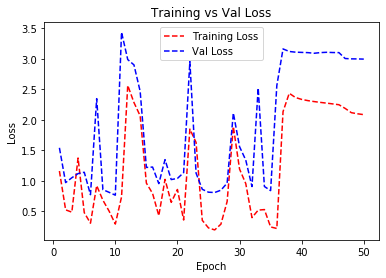

In [38]:
# Plot training vs val loss
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_losses, 'r--')
plt.plot(epoch_range, val_epoch_losses, 'b--')
plt.title('Training vs Val Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
# # Plot training vs val accuracy
# epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
# plt.plot(epoch_range, train_epoch_accs, 'r--')
# plt.plot(epoch_range, val_epoch_accs, 'b--')
# plt.title('Training vs Val Accuracy')
# plt.legend(['Training Acc', 'Val Acc'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

### Evaluate model and test prediction

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(manager.latest_checkpoint)

In [40]:
# Testing
test_steps_per_epoch = len(test_inp_data)//batch_sz
test_total_loss = 0.0
test_loss = 0.0
enc_hidden = encoder.initialize_hidden_state()
enc_cell = encoder.initialize_cell_state()

for (_, (inp, targ)) in enumerate(test_dataset.take(test_steps_per_epoch)):
  test_batch_loss = test_step(inp, targ, enc_hidden, enc_cell)
  test_total_loss += test_batch_loss
  
# Testing
test_loss = test_total_loss/test_steps_per_epoch   

print('Testing Loss: {:.4f}'.format(test_loss))

Testing Loss: 0.7964


In [0]:
rand = np.random.randint(0, len(test_inp_data)) # Change here
print(rand)
test = test_inp_data[rand] # Change here
test = convert(input_tokenizer, test, send_back=True)
test = ' '.join(test)
print('Test Sequence: {}'.format(test))

5872
Test Sequence: <s> viec tao ra cac ban in nay goi la che ban . <e>


In [0]:
test_tar = convert(target_tokenizer, test_tar_data[rand], send_back=True) # Change here
test_tar = ' '.join(test_tar)
print('Original: {}'.format(test_tar))
print('Predicted: {}'.format('<s> ' + restore(test)))

Original: <s> việc tạo ra các bản in này gọi là chế bản . <e>
Predicted: <s> việc tạo ra các bản in này gọi là chế bản . <e> 


In [41]:
prediction = []
target = []

for i in range(len(test_inp_data)):
  input = ' '.join(convert(input_tokenizer, test_inp_data[i], send_back=True))
  prediction.append(('<s> ' + restore(input)).strip())

In [42]:
for i in range(len(test_tar_data)):
  tar = convert(target_tokenizer, test_tar_data[i], send_back=True)
  target.append(' '.join(tar))

In [43]:
correct = 0
indicies = []

for i in range(len(test_inp_data)):
  if prediction[i] == target[i]:
    indicies.append(i)
    correct += 1

print(correct)    
print('Accuracy: {:.4f}%'.format(correct/len(test_inp_data)*100))

54
Accuracy: 1.8000%


In [48]:
for idx in indicies:
    print('Idx: {}, Length: {}'.format(idx, len(prediction[idx].split())))

Idx: 11, Length: 23
Idx: 50, Length: 11
Idx: 57, Length: 14
Idx: 72, Length: 16
Idx: 100, Length: 33
Idx: 124, Length: 15
Idx: 176, Length: 16
Idx: 314, Length: 15
Idx: 323, Length: 19
Idx: 332, Length: 20
Idx: 354, Length: 16
Idx: 430, Length: 12
Idx: 499, Length: 25
Idx: 521, Length: 12
Idx: 630, Length: 14
Idx: 699, Length: 17
Idx: 744, Length: 22
Idx: 756, Length: 22
Idx: 850, Length: 14
Idx: 898, Length: 18
Idx: 901, Length: 30
Idx: 919, Length: 20
Idx: 1004, Length: 15
Idx: 1009, Length: 12
Idx: 1225, Length: 10
Idx: 1255, Length: 18
Idx: 1308, Length: 19
Idx: 1315, Length: 21
Idx: 1354, Length: 17
Idx: 1356, Length: 17
Idx: 1378, Length: 23
Idx: 1389, Length: 20
Idx: 1433, Length: 17
Idx: 1495, Length: 24
Idx: 1517, Length: 14
Idx: 1541, Length: 16
Idx: 1639, Length: 19
Idx: 1661, Length: 14
Idx: 1711, Length: 22
Idx: 1739, Length: 16
Idx: 1777, Length: 21
Idx: 1927, Length: 25
Idx: 1991, Length: 36
Idx: 2002, Length: 27
Idx: 2010, Length: 32
Idx: 2016, Length: 13
Idx: 2088, Len

In [49]:
print(prediction[100])
print(target[100])

<s> có lẽ nó có xuất xứ từ các đại biểu của thuyết nhất thiết hữu bộ , nhưng nó lại được sử dụng thường xuyên trong văn học đại thừa . <e>
<s> có lẽ nó có xuất xứ từ các đại biểu của thuyết nhất thiết hữu bộ , nhưng nó lại được sử dụng thường xuyên trong văn học đại thừa . <e>


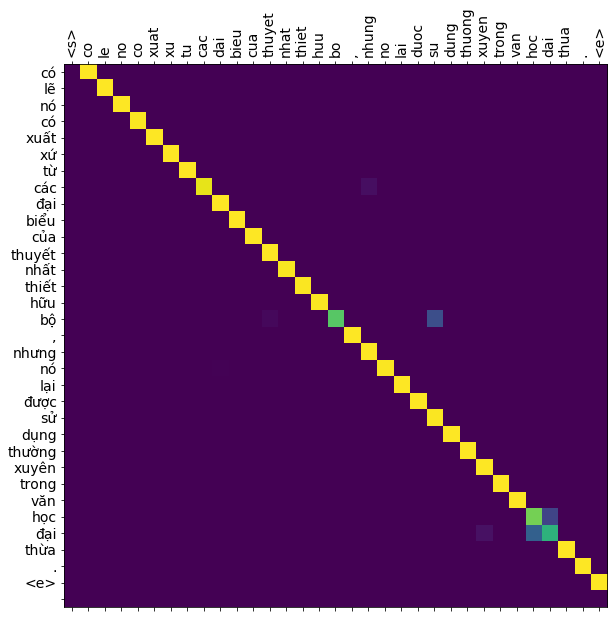

'có lẽ nó có xuất xứ từ các đại biểu của thuyết nhất thiết hữu bộ , nhưng nó lại được sử dụng thường xuyên trong văn học đại thừa . <e> '

In [53]:
restore(' '.join(convert(input_tokenizer, test_inp_data[100], True)), plot=True)